<a href="https://colab.research.google.com/github/jgracie52/CAP4630/blob/master/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
from tensorflow.python.client import device_lib
for x in device_lib.list_local_devices():
   if x.device_type == "GPU":
     print("***** GPU Information *****")
     print("Device Name: " , x.name)
     print("Memory Limit: " , "%.2f" % float(x.memory_limit/(1000*1000*1000)), "GB")
     print("Description: " , x.physical_device_desc)


***** GPU Information *****
Device Name:  /device:GPU:0
Memory Limit:  15.96 GB
Description:  device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
!ls "/content/drive/My Drive"

'Azrael: Book.gdoc'   HW3.ipynb			  'Tesla Coil.gslides'
'Colab Notebooks'    'Miniature Tesla Coil.gdoc'   trained_models
 HW1-AvgMNIST.ipynb   RuTanks7000_v1.zip	   trained_models.zip
 HW2-Problem2.ipynb   Speech.gdoc		   world.zip
 HW2-Problem3.ipynb   Synopsis.gdoc


In [34]:
!apt install unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.


In [36]:
!unzip -q "/content/drive/My Drive/RuTanks7000_v1.zip"

replace RuTanks7000_v1/test/Background/Background_01.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace RuTanks7000_v1/test/Background/Background_01.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [42]:
!ls drive/'My Drive'/trained_models

RuTanks7000_v1_l1.h5  RuTanks7000_v1_l2.h5  trained_weights


Found 42000 images belonging to 6 classes.
Found 90 images belonging to 6 classes.

### LEVEL1 ###
pretrained network:
Model: "NASNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 331, 331, 3)  0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 165, 165, 96) 2592        input_4[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 165, 165, 96) 384         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_781 (Activation)     (None, 165, 165, 96) 0           stem_bn1

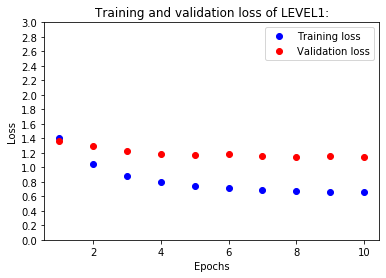

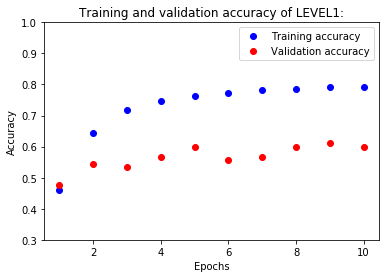


### LEVEL1 Training finished successfully ###

Loading trained weights from drive/My Drive/trained_models/trained_weights/weights_temp.h5 ...

### Saving Level1 Model to  drive/My Drive/trained_models/RuTanks7000_v1_l1.h5  ... 

### LEVEL2 ###

Loading trained weights from drive/My Drive/trained_models/trained_weights/weights_temp.h5 ...

trainable layers before unfreezing the base network up to normal_add_1_15:  510
trainable layers after the base network unfreezed from layer normal_add_1_15:  71

LEVEL2 Model after unfreezing the base network
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Model)               (None, 11, 11, 4032)      84916818  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 4032)              0         
_________________________________________________________________
dense_1 (Dense)              (

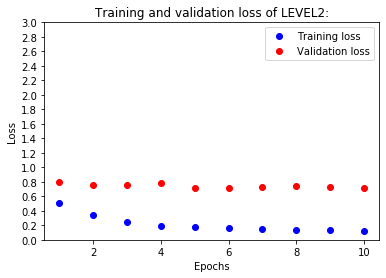

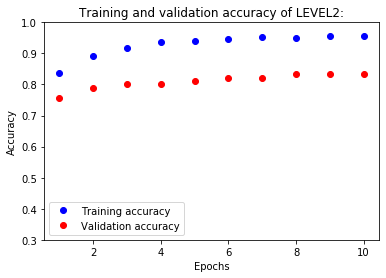


###LEVEL2 Training finished successfully ###
Time elapsed in minutes:  114.58541993654998


In [49]:
# Ugur Uysal
# ugur.uysal.86@gmail.com
# 02. Aug 2019

# imports
import os
from keras.applications import NASNetLarge
from keras import models, layers, optimizers, backend
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard
import matplotlib.pyplot as plt
import numpy as np
from timeit import default_timer as timer


def main():
    start = timer()
    level1()  # Training the classifier only
    level2()  # Training the pretrained model + the trained classifier from level 1
    end = timer()
    print("Time elapsed in minutes: ", ((end - start)/60))

# Setting Parameters ##################################################################
# image settings
img_height,img_width = 331, 331  # For NASNetLarge

# classes
classnames = ["Background", "BMP2", "Buk-M1-2", "T14", "T90", "ZSU23"]
classes = len(classnames)

# path settings
dataset_path = 'RuTanks7000_v1/'
weights_path = 'drive/My Drive/trained_models/trained_weights/weights_temp.h5'
model_path = 'drive/My Drive/trained_models/RuTanks7000_v1_'
#TensorBoardLogDir = path+'logs'

nbrTrainImages = 7000  # per class
nbrTestImages = 0  # Value gets accurate after counting (Total Number of test images)
for ImagesClass in os.listdir(dataset_path+'test/'):
    nbrTestImages += len(os.listdir(dataset_path+'test/'+ImagesClass))

# unfreezing the base network up to a specific layer in Level2:
freezeUptoLayer = "normal_add_1_15"   # NASNetLarge

# hyperparameters
learning_rate = 0.0002  # Learning_rate in Level 2 = learning_rate/10
lr_decay = 0.00005
batch = 128
fcLayer1 = 32
dropout = 0.5

epochsL1 = 10
patiencel1 = 1
factorL1 = 0.5

epochsL2 = 10
patiencel2 = 1
factorL2 = 0.5

verbose_train = 1

# datagenerators https://keras.io/preprocessing/image/
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
    dataset_path+'train',
    target_size=(img_height, img_width),
    batch_size=batch,
    shuffle=True,
    classes=classnames,
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    dataset_path+'test',
    target_size=(img_height, img_width),
    batch_size=1,
    shuffle=True,
    classes=classnames,
    class_mode='categorical')
#########################################################################################

# function to plot results of model performance
def plot(h,t,e):
    history_dict = h[0]
    loss_values = history_dict['loss']
    validation_loss_values = history_dict['val_loss']
    acc_values = history_dict['acc']
    validation_acc_values = history_dict['val_acc']
    epochs_range = range(1, e + 1)

    # Plotting Training and Validation loss of the corresponding Model
    plt.plot(epochs_range, loss_values, 'bo', label='Training loss')
    plt.plot(epochs_range, validation_loss_values, 'ro', label='Validation loss')
    plt.title('Training and validation loss of ' + t)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yticks(np.arange(0, 3.1, step=0.2))
    plt.legend()
    plt.show()

    # Plotting Training and Validation accuracy of the corresponding Model
    plt.plot(epochs_range, acc_values, 'bo', label='Training accuracy')
    plt.plot(epochs_range, validation_acc_values, 'ro', label='Validation accuracy')
    plt.title('Training and validation accuracy of ' + t)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.yticks(np.arange(0.3, 1.1, step=0.1))
    plt.legend()
    plt.show()


# LEVEL1 - Training of densely connected layers
def level1():
    # Building the model using the pretrained model
    conv_base1 = NASNetLarge(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
    print("\n### LEVEL1 ###\npretrained network:")
    conv_base1.summary()
    model = models.Sequential()
    model.add(conv_base1)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(fcLayer1, activation='relu'))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(classes, activation='softmax'))

    # freezing the base network
    print("trainable layers befor freezing:", int(len(model.trainable_weights)/2)) # weights = weights + bias = 2 pro layer
    conv_base1.trainable = False
    print("trainable layers after freezing:", int(len(model.trainable_weights)/2))
    print("\npretrained network + densely connected classifier")
    model.summary()

    # training the added layers only
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=learning_rate, decay=lr_decay), metrics=['acc'])

    callbacks_list_L1 = [ModelCheckpoint(filepath=weights_path, save_weights_only=True, monitor='val_acc', verbose=1, save_best_only=True),
                      ReduceLROnPlateau(monitor='val_acc', factor=factorL1, patience=patiencel1, verbose=1)#,
                      #TensorBoard(log_dir=TensorBoardLogDir+'\\level1')
                      ]

    print("\n### Level1 Training ... ")
    # training the model
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=(nbrTrainImages * classes) // (batch * 4),
        epochs=epochsL1,
        callbacks=callbacks_list_L1,
        validation_data=test_generator,
        validation_steps=nbrTestImages,
        verbose=verbose_train)

    history_val1 = [history.history]  # saving all results of the final test
    plot(history_val1, "LEVEL1:", epochsL1)
    print("\n### LEVEL1 Training finished successfully ###")

    print("\nLoading trained weights from " + weights_path + " ...")
    model.load_weights(weights_path)
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=learning_rate), metrics=['acc'])
    print("\n### Saving Level1 Model to ", model_path+'l1.h5', " ... ")
    model.save(model_path+'l1.h5')


# LEVEL2 - Training pretrained network and trained densely connected layers
def level2():
    # Destroying the current TF graph - https://keras.io/backend/
    backend.clear_session()
    print("\n### LEVEL2 ###")
    conv_base2 = NASNetLarge(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
    model2 = models.Sequential()
    model2.add(conv_base2)
    model2.add(layers.GlobalAveragePooling2D())
    model2.add(layers.Dense(fcLayer1, activation='relu'))
    model2.add(layers.Dropout(dropout))
    model2.add(layers.Dense(classes, activation='softmax'))

    print("\nLoading trained weights from " + weights_path + " ...")
    model2.load_weights(weights_path)

    # unfreezing the base network up to a specific layer:
    if freezeUptoLayer == "":
        conv_base2.trainable = True
        print ("\ntrainable layers: ",int(len(model2.trainable_weights) / 2))
    else:
        print("\ntrainable layers before unfreezing the base network up to " + freezeUptoLayer + ": ",int(len(model2.trainable_weights) / 2))  # weights = weights + bias = 2 pro layer
        conv_base2.trainable = True
        set_trainable = False
        for layer in conv_base2.layers:
            if layer.name == freezeUptoLayer: set_trainable = True
            if set_trainable: layer.trainable = True
            else: layer.trainable = False
        print("trainable layers after the base network unfreezed from layer " + freezeUptoLayer + ": ", int(len(model2.trainable_weights)/2))

    print("\nLEVEL2 Model after unfreezing the base network")
    model2.summary()
    model2.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=learning_rate/10, decay=lr_decay), metrics=['acc'])
    print ("\n### Validating ... ")

    val_loss, val_acc = model2.evaluate_generator(test_generator, steps=nbrTestImages, verbose=0)
    print('Validation Results before training unfreeze layers and trained densely connected layers:\nValidation loss:',val_loss,",",'Validation accuracy:', val_acc, "\n")

    # Jointly training both the unfreeze layers and the added trained densely connected layers
    callbacks_list_L2 = [ModelCheckpoint(filepath=model_path+'l2.h5', save_weights_only=False, monitor='val_acc', verbose=1, save_best_only=True),
                      ReduceLROnPlateau(monitor='val_acc', factor=factorL2, patience=patiencel2, verbose=1)#,
                      #TensorBoard(log_dir=TensorBoardLogDir+'\\level2')
                      ]

    print ("\n### Level2 Training ... ")
    history = model2.fit_generator(
        train_generator,
        steps_per_epoch=(nbrTrainImages * classes) // (batch * 4),
        epochs=epochsL2,
        callbacks=callbacks_list_L2,
        validation_data=test_generator,
        validation_steps=nbrTestImages,
        verbose=verbose_train)

    history_val2 = [history.history]  # saving all results of the final test
    plot(history_val2, "LEVEL2:", epochsL2)
    print("\n###LEVEL2 Training finished successfully ###")


main()

# References
# Chollet, F. (2018). Deep learning with Python. Section 5.3 - Using a pretrained convnet.